
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./Ogata-Banks.ipynb" download="Ogata-Banks.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=Ogata-Banks.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/TH2M/TH/Ogata-Banks/Ogata-Banks.py"><img src="https://img.shields.io/static/v1?label=Source:&message=Ogata-Banks.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/TH2M/TH/Ogata-Banks/Ogata-Banks.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

|<div style="width:300px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:300px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

# Advective-Diffusive transport (Ogata-Banks)

The Ogata-Banks analytical solution of the 1D advection-dispersion equation of heat for a point $x$ in time $t$ reads:

$ T(x,t) = \frac{T_0-T_i}{2}\left[\operatorname{erfc}\left(\frac{x-v_xt}{\sqrt{4Dt}}\right)+\operatorname{exp}\left(\frac{xv_x}{D}\right)\operatorname{erfc}\left(\frac{x+v_xt}{\sqrt{4Dt}}\right)\right]+T_i$

where $T_0$ is the constant temperature at $x=0$ and $T_i$ is initial temperature at $t=0$, $v_x$ is the constant velocity of the fluid medium, and D is thermal diffusivity given by

$D=\frac{\lambda}{\rho c_p}$

where $\lambda$ is the thermal heat conductivity, $\rho$ is density and $c_p$ is the specific heat capacity of the fluid medium.

---

The weak form of the energy balance equation (in simplified form for single-phase fluid L and without gravity) in OGS-TH2M is:

$
\int_\Omega
(\Sigma_\alpha\rho_\alpha u_\alpha)'_\mathrm{S}
\,\delta T\,d\Omega
-\int_\Omega \rho_\mathrm{L} h_\mathrm{L}\mathbf{w}_\mathrm{LS}\cdot\nabla\delta T\,d\Omega
+\int_\Omega \lambda^\mathrm{eff}\nabla T\cdot\nabla\,\delta T\,d\Omega
+\int_{\partial\Omega}\underbrace{\left(\lambda^\mathrm{eff}\nabla T
-\rho_\mathrm{L}h_\mathrm{L}\mathbf{w}_\mathrm{LS}\right)\cdot\mathbf{n}}_{=-q_n}\,\delta T\,d\Gamma
$

This results in an energy contribution across the Neumann boundaries that is dependent on the flowing medium and which may have to be compensated for by the boundary conditions.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv
from scipy.special import erfc

## Material properties

In [2]:
rho_eff = 1000
cp_eff = 2000
lambda_eff = 2.2
phi = 0.15  # Porosity
alpha = lambda_eff / (rho_eff * cp_eff)  # Thermal diffusivity

## Problem definition

In [3]:
T_i = 300  # Initial temperature
T_0 = 330  # Boundary condition left
v_x = 1.5e-6  # Groundwater velocity
delta_t = 0.5 * 86400
max_time = 500 * 86400

## Analytical solution

In [4]:
def ogata_banks_analytical(t, x):
    d = np.sqrt(4.0 * alpha * t)
    a1 = np.divide(x - v_x * t, d, where=t != 0, out=np.ones_like(x * d) * 1e6)
    a2 = np.divide(x + v_x * t, d, where=t != 0, out=np.ones_like(x * d) * 1e6)
    erfc_term = erfc(a1) + np.exp(v_x * x / alpha) * erfc(a2)
    return 0.5 * (T_0 - T_i) * erfc_term + T_i

## Numerical solution

In [5]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [6]:
model = ot.Project(input_file="ogata-banks.prj", output_file=f"{out_dir}/modified.prj")
timestepping = "./time_loop/processes/process/time_stepping"
model.replace_text(max_time, xpath=f"{timestepping}/t_end")
model.replace_text(delta_t, xpath=f"{timestepping}/timesteps/pair/delta_t")
model.replace_text(1, xpath="./time_loop/output/timesteps/pair/each_steps")
model.replace_text("XDMF", xpath="./time_loop/output/type")
model.write_input()

In [7]:
# Run OGS
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m . -s .")

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/TH2M/TH/Ogata-Banks/Ogata-Banks/modified.prj
Status: finished successfully.
Execution took 36.54406785964966 s


In [8]:
ms = ot.MeshSeries(f"{out_dir}/result_ogata-banks_domain.xdmf")
var = ot.variables.temperature


def plot_results_errors(
    x: np.ndarray, y: np.ndarray, y_ref: np.ndarray, labels: list, x_label: str
):
    "Plot numerical results against analytical solution"
    rel_errors = (np.asarray(y) - np.asarray(y_ref)) / np.asarray(y_ref)
    assert np.all(np.abs(rel_errors) <= 0.0025)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    ax1.set_ylabel(var.get_label())
    ax2.set_ylabel("relative error")
    for i, rel_error in enumerate(rel_errors):
        ax1.plot(x, var.transform(y[i]), f"--C{i}", lw=2, label=labels[i])
        ax1.plot(x, var.transform(y_ref[i]), f"-C{i}", lw=1)
        ax2.plot(x, rel_error, f"-C{i}", lw=2)
    ax1.plot([], [], "--k", lw=2, label="numerical")
    ax1.plot([], [], "-k", lw=1, label="analytical")
    ax1.legend()
    fig.tight_layout()

## Temperature over time at different locations

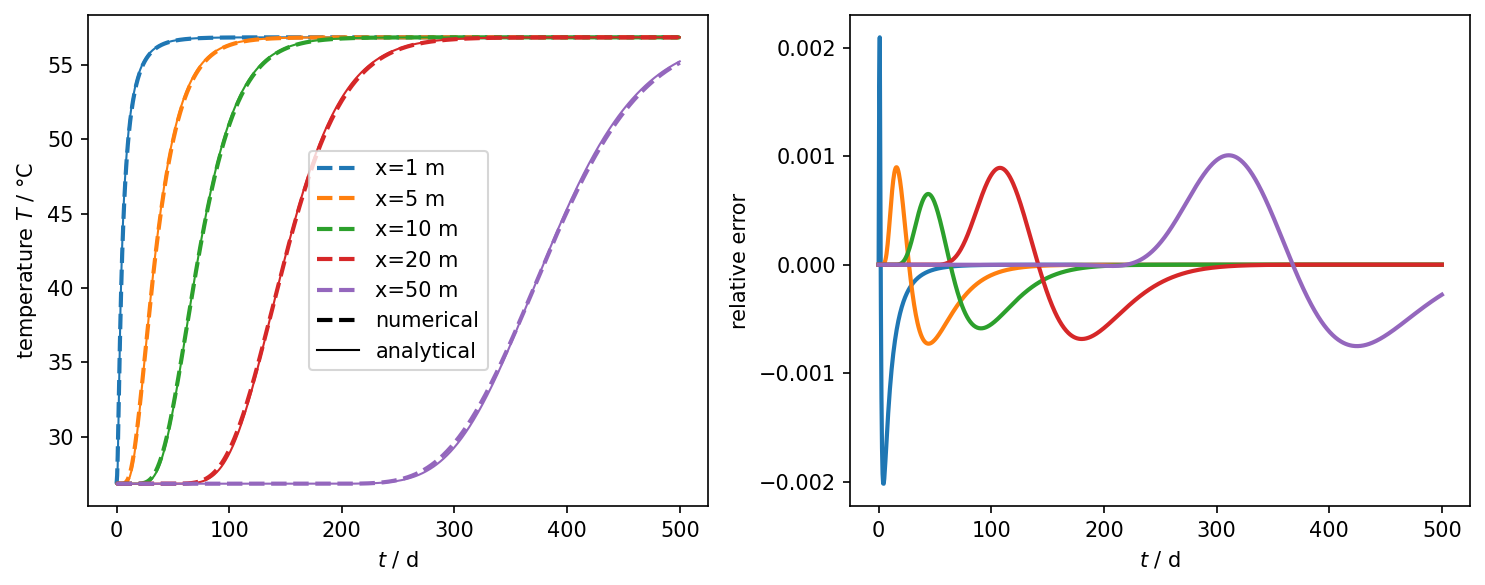

In [9]:
obs_pts = np.asarray([[x, 0, 0] for x in [1, 5, 10, 20, 50]])
num_values = ms.probe(obs_pts, "temperature").T
ref_values = [ogata_banks_analytical(ms.timevalues, x) for x in obs_pts[:, 0]]
leg_labels = [f"x={pt[0]} m" for pt in obs_pts]
ms = ms.scale(time=("s", "days"))
time = ms.timevalues
plot_results_errors(time, num_values, ref_values, leg_labels, "$t$ / d")

## Temperature over x at different timesteps

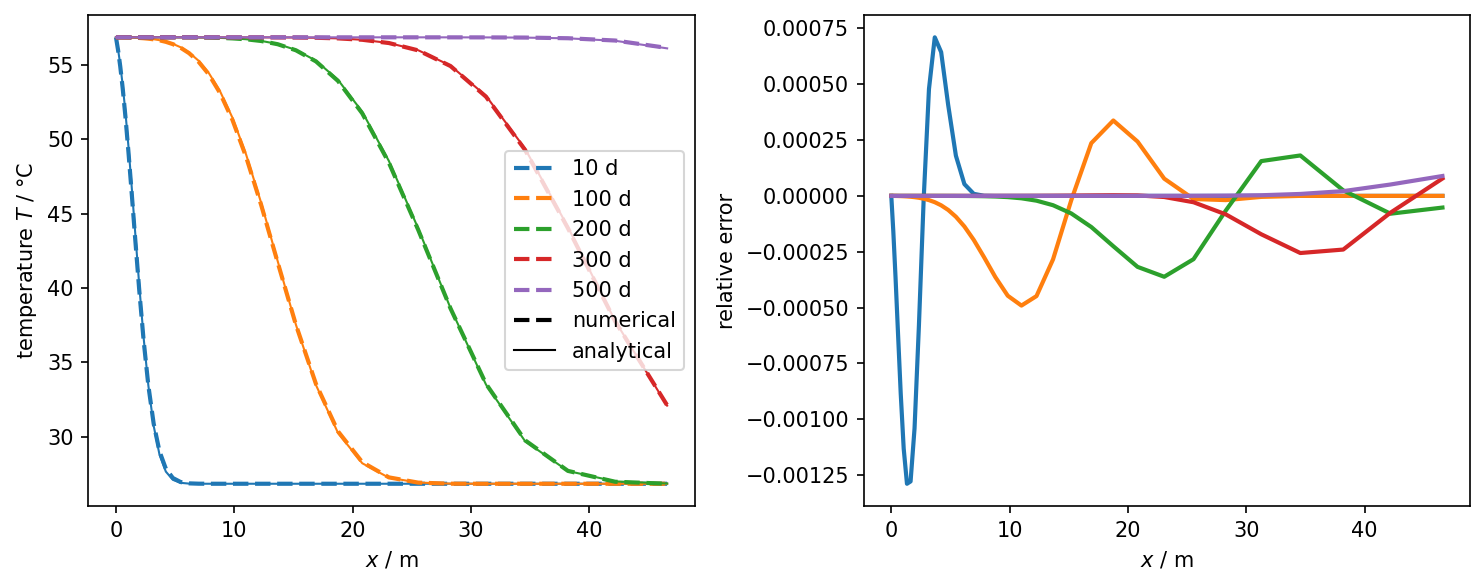

In [10]:
timevalues = np.asarray([10, 100, 200, 300, 500])
timesteps = [ms.closest_timestep(tv) for tv in timevalues]
all_pts = ms.mesh(0).points
pts = all_pts[(all_pts[:, 0] <= 50) & (all_pts[:, 1] == 0)]
line = pv.PointSet(pts)
num_values = [line.sample(ms.mesh(ts))["temperature"] for ts in timesteps]
ref_values = [ogata_banks_analytical(tv * 86400, pts[:, 0]) for tv in timevalues]
leg_labels = [f"{tv} d" for tv in timevalues]
plot_results_errors(pts[:, 0], num_values, ref_values, leg_labels, "$x$ / m")

## Temperature over time and space

/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/.venv/lib/python3.13/site-packages/ogstools/meshlib/mesh_series.py:910: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(x_vals, y_vals, values, cmap=cmap, norm=norm)


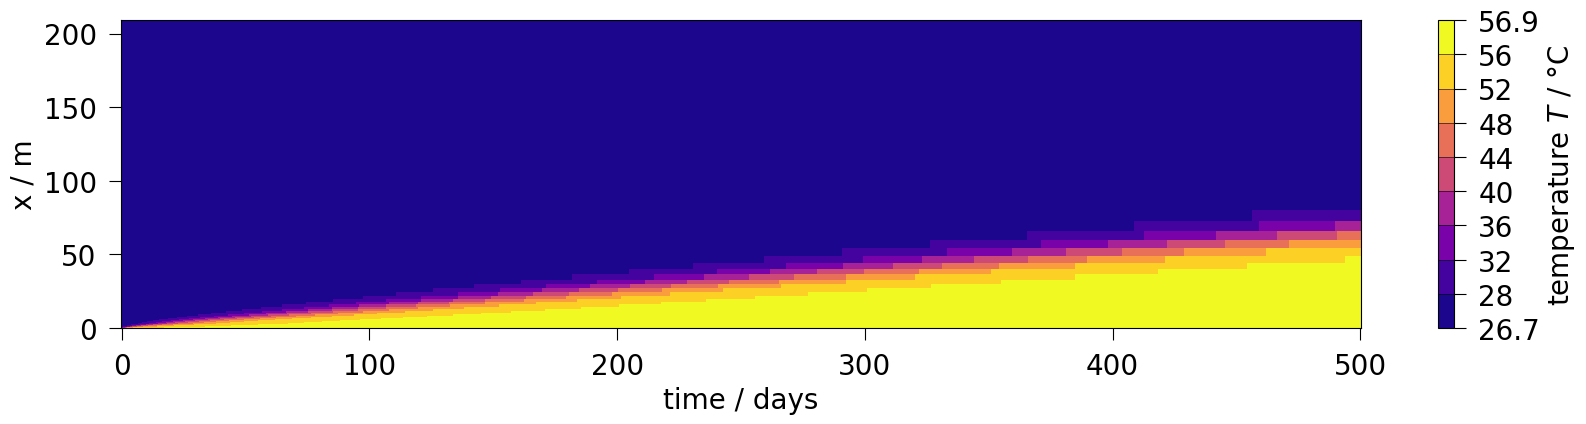

In [11]:
ot.plot.setup.time_unit = "days"
fig = ms.plot_time_slice("time", "x", var, figsize=(20, 4), fontsize=20)

For this discretisation, the numerical solution approximates well to the analytical one. Finer resolutions in the time discretisation reduce the deviations considerably. In this benchmark it is easy to see that too coarse resolutions (especially in the time discretisation) yield very plausible results, which can, however, deviate considerably from the exact solution. An analysis of the von Neumann stability criterion is worthwhile here. This criterium demands

$$\text{Ne}=\frac{\alpha\Delta t}{\left(\Delta x\right)^2}\leq\frac{1}{2}$$

Evaluated for the problem at hand, the following value results:

In [12]:
dx = 0.17  # Spatial discretizations at the left boundary (smallest element)
Ne = alpha * delta_t / (dx * dx)  # von-Neumann-Stability-Criterion
print(Ne)

1.644290657439446


The Neumann criterion is not met in this case. The smallest element is $\Delta x=0.17\text{m}$ in width. A suitable time step for this cell size would be

In [13]:
dt = 0.5 * (dx * dx) / alpha
print("Smallest timestep should not exceed", dt, "seconds.")

Smallest timestep should not exceed 13136.363636363638 seconds.


Repeating the test with this time step should give much smaller deviations to the exact solution.

However, the problem at hand has been spatially discretised where element widths are increasing from left to right. That means that the stability criteria is violated only at the left region of the domain.
The minimum width that an element should have is can be determined by:

In [14]:
dx = np.sqrt(2 * alpha * delta_t)
print("Minimum element size should be", dx, " metre.")

Minimum element size should be 0.3082855818879631  metre.


The elements located at approximately $x>1\text{m}$ satisfy this criterion, therefore the solution presented here can be accepted as an approximation of the exact solution.